In [1]:
#加载全部数据到内存中
def get_data():
    from datasets import load_dataset
    import numpy as np

    #加载
    dataset = load_dataset('lansinuote/gen.1.celeba', split='train')

    #采样
    dataset = dataset.shuffle(0).select(range(2000))

    #图片转数据
    def f(data):
        images = data['image']

        data = []
        for i in images:
            i = i.resize((64, 64))
            i = np.array(i)
            i = (i - 127.5) / 127.5
            i = i.transpose(2, 0, 1)
            data.append(i)
        return {'image': data}

    dataset = dataset.map(function=f,
                          batched=True,
                          batch_size=1000,
                          num_proc=4,
                          remove_columns=list(dataset.features)[1:])

    #加载为numpy数据
    data = np.empty((2000, 3, 64, 64), dtype=np.float32)
    for i in range(len(dataset)):
        data[i] = dataset[i]['image']

    return data


data = get_data()

data.shape, data.min(), data.max()

Using custom data configuration lansinuote--gen.1.celeba-cdea5a503bf57939
Found cached dataset parquet (/root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-5eb78bab229fe5c7.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-03f004c5291f580c.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-e4d1bc770bb4c72e.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-f3c2638206a5e78a.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-819c8d4ea96c983d.arrow


((2000, 3, 64, 64), -1.0, 1.0)

In [2]:
import torch

loader = torch.utils.data.DataLoader(
    dataset=data,
    batch_size=64,
    shuffle=True,
    drop_last=True,
)

len(loader), next(iter(loader)).shape

(31, torch.Size([64, 3, 64, 64]))

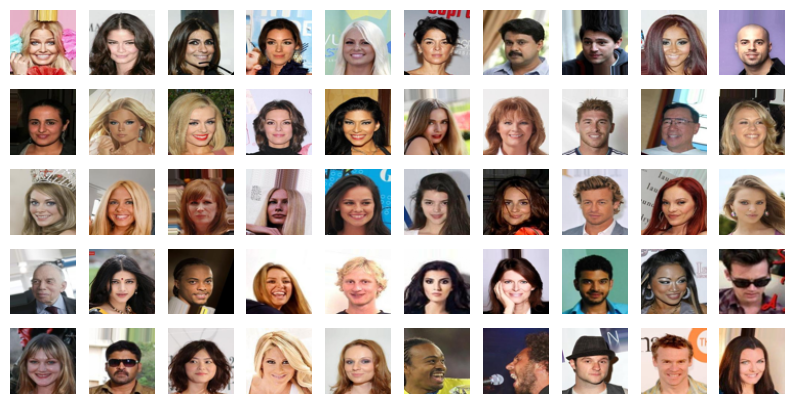

In [3]:
def show(images):
    from matplotlib import pyplot as plt

    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()

    images = images[:50]

    plt.figure(figsize=(10, 5))

    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)
        image = (image + 1) / 2

        plt.subplot(5, 10, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


show(next(iter(loader)))

In [4]:
class Block(torch.nn.Module):

    def __init__(self, dim_in, dim_out, is_encoder=True):
        super().__init__()

        cnn_type = torch.nn.Conv2d
        if not is_encoder:
            cnn_type = torch.nn.ConvTranspose2d

        def block(dim_in, dim_out, kernel_size=3, stride=1, padding=1):
            return (
                cnn_type(dim_in,
                         dim_out,
                         kernel_size=kernel_size,
                         stride=stride,
                         padding=padding),
                torch.nn.BatchNorm2d(dim_out),
                torch.nn.LeakyReLU(),
            )

        self.s = torch.nn.Sequential(
            *block(dim_in, dim_in),
            *block(dim_in, dim_in),
            *block(dim_in, dim_in),
            *block(dim_in, dim_out, kernel_size=3, stride=2, padding=0),
            *block(dim_out, dim_out),
            *block(dim_out, dim_out),
            *block(dim_out, dim_out),
        )

        self.res = cnn_type(dim_in,
                            dim_out,
                            kernel_size=3,
                            stride=2,
                            padding=0)

    def forward(self, x):
        return self.s(x) + self.res(x)


Block(3, 5)(torch.randn(2, 3, 20, 20)).shape

torch.Size([2, 5, 9, 9])

In [5]:
encoder = torch.nn.Sequential(
    Block(3, 32, True),
    Block(32, 64, True),
    Block(64, 128, True),
    Block(128, 256, True),
    torch.nn.Flatten(),
    torch.nn.Linear(2304, 128),
)

encoder(torch.randn(2, 3, 64, 64)).shape

torch.Size([2, 128])

In [6]:
decoder = torch.nn.Sequential(
    torch.nn.Linear(128, 256 * 4 * 4),
    torch.nn.InstanceNorm1d(256 * 4 * 4),
    torch.nn.Unflatten(dim=1, unflattened_size=(256, 4, 4)),
    Block(256, 128, False),
    Block(128, 64, False),
    Block(64, 32, False),
    Block(32, 3, False),
    torch.nn.UpsamplingNearest2d(size=64),
    torch.nn.Conv2d(in_channels=3,
                    out_channels=3,
                    kernel_size=1,
                    stride=1,
                    padding=0),
    torch.nn.Tanh(),
)

decoder(torch.randn(2, 128)).shape

torch.Size([2, 3, 64, 64])

In [7]:
class VAE(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        #两个全连接层
        self.fc_mu = torch.nn.Linear(128, 128)
        self.fc_log_var = torch.nn.Linear(128, 128)

    def forward(self, data):
        hidden = self.encoder(data)
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)

        randn = torch.randn(mu.shape, device=hidden.device)
        hidden = mu + (log_var / 2).exp() * randn

        return self.decoder(hidden), mu, log_var


vae = VAE()

pred, mu, log_var = vae(torch.randn(2, 3, 64, 64))

pred.shape, mu.shape, log_var.shape

(torch.Size([2, 3, 64, 64]), torch.Size([2, 128]), torch.Size([2, 128]))

In [8]:
optimizer = torch.optim.Adam(vae.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,
                                              start_factor=1,
                                              end_factor=0,
                                              total_iters=1000 * len(loader))
criterion = torch.nn.MSELoss(reduction='none')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae.to(device)
vae.train()

device

'cuda'

0 3695.385009765625 0.00019979999999999992


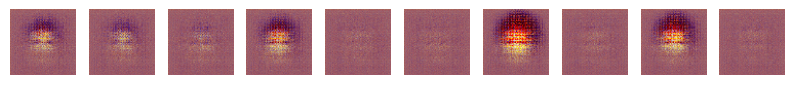

50 538.5194091796875 0.00018979999999999567


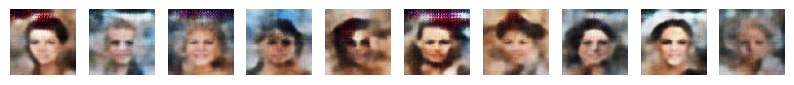

100 408.0197448730469 0.00017979999999999136


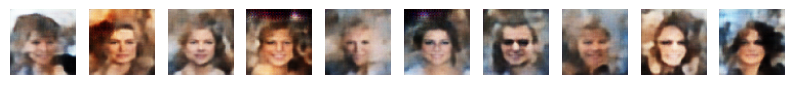

150 330.3363037109375 0.00016979999999998705


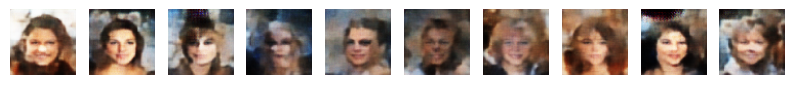

200 289.7785339355469 0.00015979999999998274


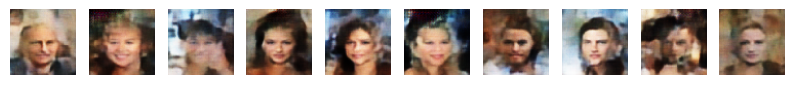

250 249.56982421875 0.00014979999999997843


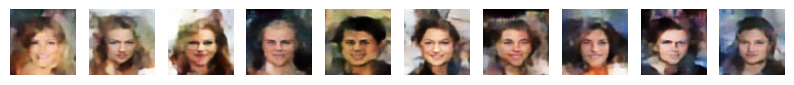

300 245.89923095703125 0.00013979999999997412


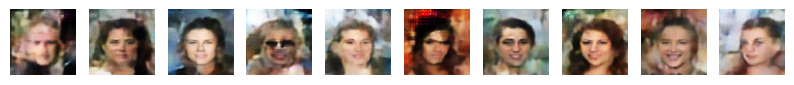

350 218.7740478515625 0.00012979999999996982


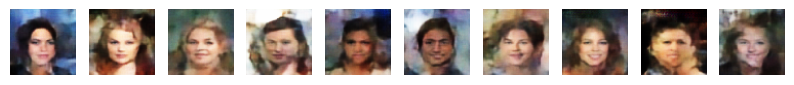

400 201.3290557861328 0.00011979999999996705


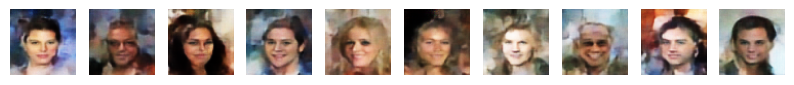

450 190.6419677734375 0.00010979999999996942


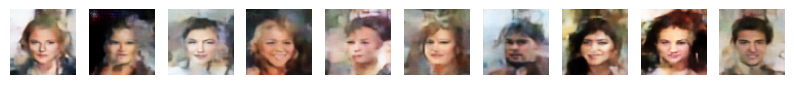

500 183.6572265625 9.979999999997104e-05


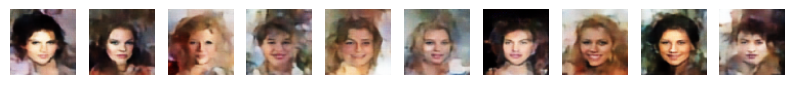

550 177.33132934570312 8.979999999997328e-05


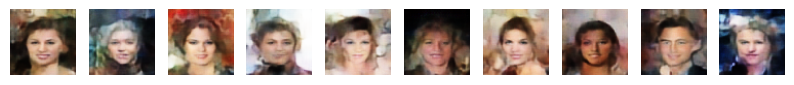

600 168.76901245117188 7.97999999999742e-05


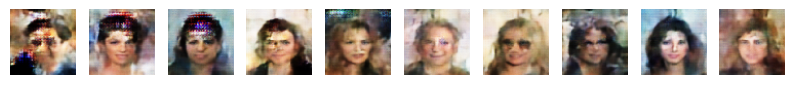

650 166.66934204101562 6.97999999999755e-05


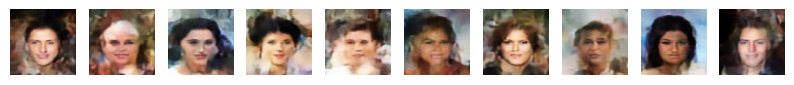

700 159.9972381591797 5.979999999997737e-05


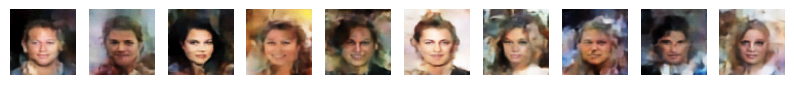

750 160.38087463378906 4.979999999998155e-05


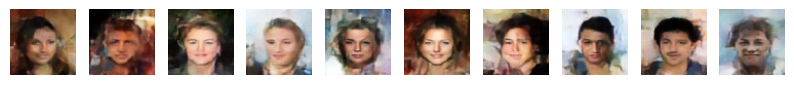

800 148.2803955078125 3.9799999999986175e-05


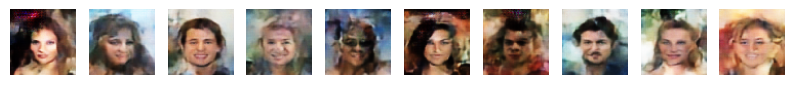

850 147.73849487304688 2.979999999999099e-05


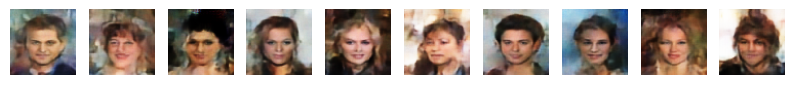

900 141.77427673339844 1.9799999999993763e-05


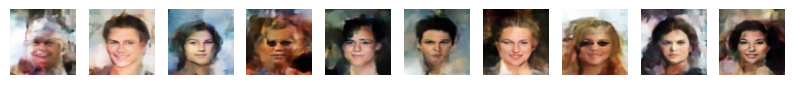

950 139.87095642089844 9.799999999996925e-06


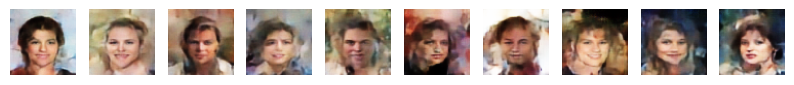

In [9]:
def train():
    for epoch in range(1000):
        for _, data in enumerate(loader):
            data = data.to(device)

            pred, mu, log_var = vae(data)

            loss_mse = criterion(pred, data) * 10000
            loss_mse = loss_mse.mean(dim=(1, 2, 3))

            loss_kl = 1 + log_var - mu**2 - log_var.exp()
            loss_kl = loss_kl.sum(dim=1) * -0.5

            loss = (loss_mse + loss_kl).mean()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

        if epoch % 50 == 0:
            print(epoch, loss.item(), optimizer.param_groups[0]['lr'])

            with torch.no_grad():
                gen = decoder(torch.randn(10, 128, device=device))
            show(gen)


local_training = True

if local_training:
    train()

In [10]:
from transformers import PreTrainedModel, PretrainedConfig


class Model(PreTrainedModel):
    config_class = PretrainedConfig

    def __init__(self, config):
        super().__init__(config)
        self.vae = vae.to('cpu')


if local_training:
    #保存训练好的模型到hub
    Model(PretrainedConfig()).push_to_hub(
        repo_id='lansinuote/gen.2.vae',
        use_auth_token=open('/root/hub_token.txt').read().strip())

pytorch_model.bin:   0%|          | 0.00/33.3M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

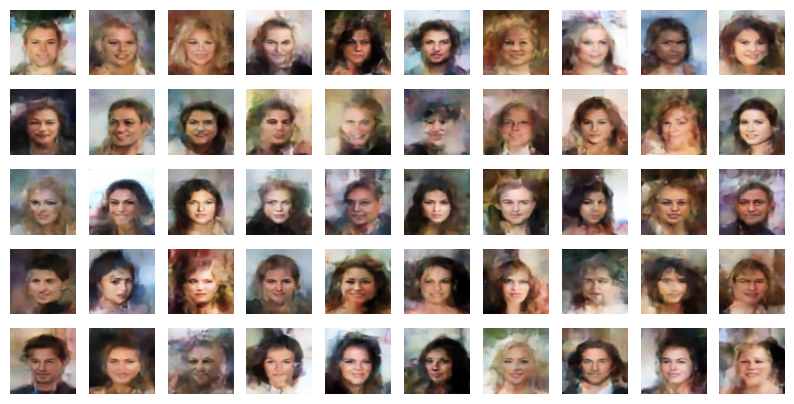

In [11]:
#加载训练好的模型
decoder = Model.from_pretrained('lansinuote/gen.2.vae').vae.decoder

with torch.no_grad():
    gen = decoder(torch.randn(50, 128))
    
show(gen)